In [1]:
%load_ext autoreload
%autoreload 2

import json
import re
import numpy as np
import cv2
import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from time import time, sleep

from utils import *
from jigsaws_utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

import warnings
warnings.simplefilter('ignore', category=np.ComplexWarning)

seed = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('Device:',torch.cuda.get_device_name(device))

def cross_predict(model, gram_matrix, y, nsplits=5, d_transform=None):
    nsample = len(y)
    nsample_per_group = int(nsample/nsplits)
    repeats = [nsample_per_group]*(nsplits-1)
    repeats = repeats + [nsample-np.sum(repeats)]
    groups = np.repeat(np.arange(nsplits), repeats)
    kfolder = GroupKFold(n_splits=nsplits)

    all_preds = []
    all_true = []
    for i, (train_index, test_index) in enumerate(kfolder.split(y, groups=groups)):
        if d_transform is not None:
            gram_train = d_transform(gram_matrix[train_index, :][:, train_index])
            gram_test = d_transform(gram_matrix[test_index, :][:, train_index])
        else:
            gram_train = gram_matrix[train_index, :][:, train_index]
            gram_test = gram_matrix[test_index, :][:, train_index]

        # Predict
        model.fit(gram_train, y[train_index])
        preds = model.predict(gram_test)
        all_preds.append(preds)
        all_true.append(y[test_index])

    return np.concatenate(all_preds), np.concatenate(all_true)

def evaluate_model(model, gram_matrix, y, gestures, nsplits=5, d_transform=None):
    nsample = len(y)
    nsample_per_group = int(nsample/nsplits)
    repeats = [nsample_per_group]*(nsplits-1)
    repeats = repeats + [nsample-np.sum(repeats)]
    groups = np.repeat(np.arange(nsplits), repeats)
    kfolder = GroupKFold(n_splits=nsplits)

    ngestures = len(gestures)
    confusion_matrix_cum = np.zeros((ngestures, ngestures))
    count_gesture_presence = np.zeros((ngestures, ngestures))
    accuracy_cum = 0
    for train_index, test_index in kfolder.split(y, groups=groups):
        if d_transform is not None:
            gram_train = d_transform(gram_matrix[train_index, :][:, train_index])
            gram_test = d_transform(gram_matrix[test_index, :][:, train_index])
        else:
            gram_train = gram_matrix[train_index, :][:, train_index]
            gram_test = gram_matrix[test_index, :][:, train_index]

        # Predict
        model.fit(gram_train, y[train_index])
        preds = model.predict(gram_test)
        accuracy_cum += np.mean(y[test_index]==preds)
        cm = confusion_matrix(y[test_index], preds, normalize='true')

        # Handle of missing gestures
        current_gesture_presence = np.ones(cm.shape)
        if cm.shape != (ngestures,ngestures):
            missing_gestures = np.setdiff1d(np.setdiff1d(gestures, preds), y[test_index])

            print(gestures, missing_gestures)
            for g in missing_gestures:
                gi = g2i[g]
                cm = np.insert(cm, gi, 0, axis=0)
                cm = np.insert(cm, gi, 0, axis=1)
                #cm[gi,gi] = 1
                print('AAA')
                print(current_gesture_presence)
                current_gesture_presence = np.insert(current_gesture_presence, gi, 0, axis=0)
                print('BBB')
                print(current_gesture_presence)
                current_gesture_presence = np.insert(current_gesture_presence, gi, 0, axis=1)
                print('CCC')
        confusion_matrix_cum += cm
        count_gesture_presence += current_gesture_presence
        print(current_gesture_presence)
    #if np.any(count_gesture_presence==0):
    #    print('In evaluate_model, zero count:')
    print('End of splits')
    print(count_gesture_presence)
    average_confusion_matrix = confusion_matrix_cum/count_gesture_presence

    accuracy = accuracy_cum / float(nsplits)
    weighted_accuracy = np.mean(np.diag(average_confusion_matrix))

    return accuracy, weighted_accuracy, average_confusion_matrix

def plot_distr(classes, counts, task, alpha=1):
    nclass = len(classes)
    x = range(nclass)
    plt.figure(figsize=(12, 8))
    plt.title('Distribution of gestures for task '+i2task[task])
    plt.bar(x, counts, alpha=alpha, width=0.5)
    plt.xticks(x, classes)
    plt.xlabel('Gesture id')
    plt.ylabel('Number of instances of gesture')
    plt.savefig('data_generated/gesture_distribution_'+i2task[task]+'.png')

Device: Tesla P100-PCIE-16GB


Missing file for: task 'Knot_Tying', subject 'B', trial 5
Missing file for: task 'Knot_Tying', subject 'H', trial 1
Missing file for: task 'Knot_Tying', subject 'H', trial 2
Missing file for: task 'Knot_Tying', subject 'I', trial 4


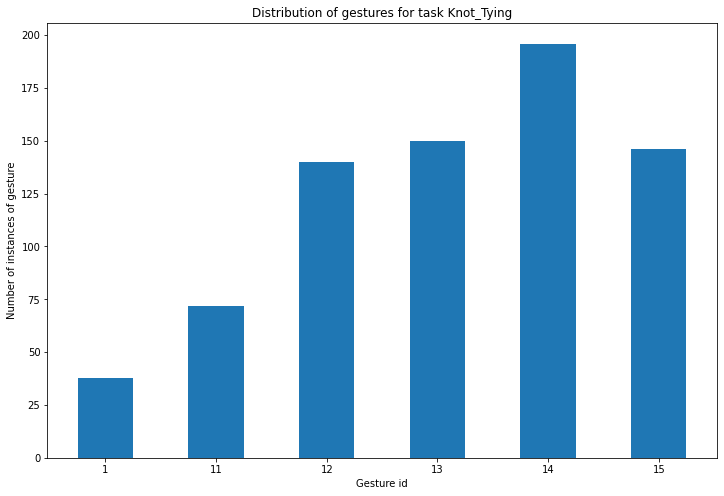

Missing file for: task 'Needle_Passing', subject 'B', trial 5
Missing file for: task 'Needle_Passing', subject 'E', trial 2
Missing file for: task 'Needle_Passing', subject 'F', trial 2
Missing file for: task 'Needle_Passing', subject 'F', trial 5
Missing file for: task 'Needle_Passing', subject 'H', trial 1
Missing file for: task 'Needle_Passing', subject 'H', trial 3
Missing file for: task 'Needle_Passing', subject 'I', trial 1


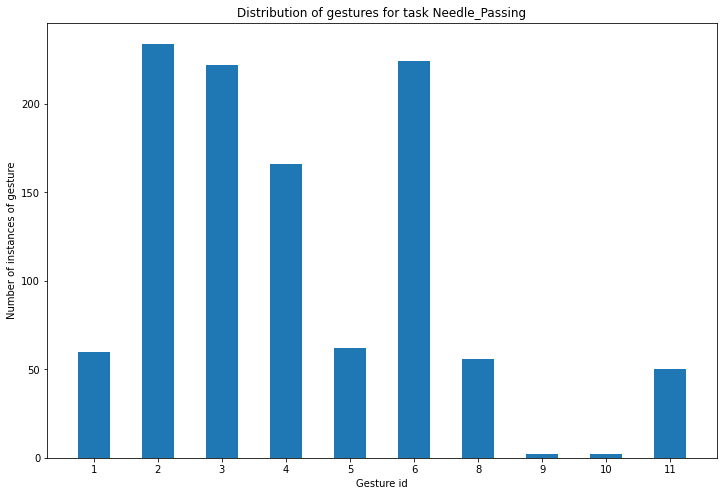

Missing file for: task 'Suturing', subject 'H', trial 2


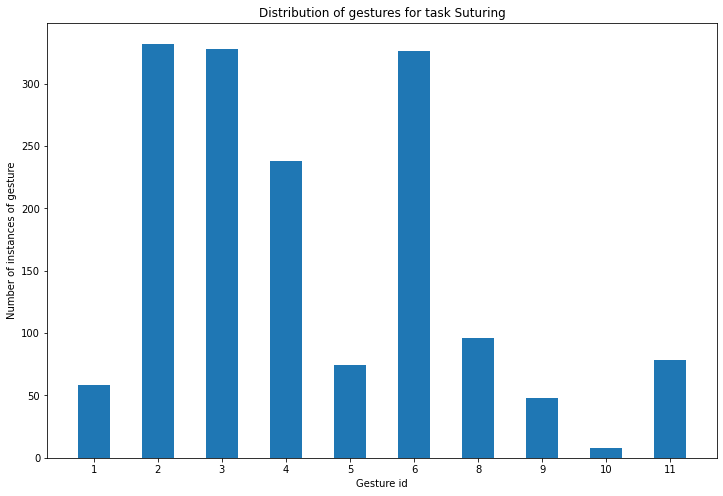

In [2]:
for task in range(3):
    _, y = load_video_data(tasks=task)
    plot_distr(*np.unique(y, return_counts=True), task)
    plt.show()

In [3]:
gestures_for_tasks = [[1,11,12,13,14,15],
                      [1,2,3,4,5,6,8,11],
                      [1,2,3,4,5,6,8,9,11]]

## Evaluation for all tasks and subjects using baseline

In [4]:
ks = np.arange(1, 8)
gammas = np.logspace(-10, -5, base=2, num=10)
ncomp = 10

task_algo_accuracies = {}
task_algo_weighted_accuracies = {}
task_algo_confusions = {}
subject_gestures = [[] for _ in range(ntask)]
start = time()
for task in range(ntask):
    print(i2task[task]+':')
    task_dir = 'data/JIGSAWS_converted/'+i2task[task]
    stream = os.popen("find %s -name '*.avi' | sed 's:^.*_\([A-Z][0-9]\{3\}\)_[^_]\+$:\\1:'" % task_dir)
    video_meta = list(filter(lambda x: x != '', stream.read().split('\n')))
    task_subjects = np.unique([x[0] for x in video_meta])

    task_gestures = gestures_for_tasks[task]

    for dist, dist_name in [(martin_dist, 'Martin'), (frob_dist, 'Frobenius')]:
        for algo, nhyper in [('KNN', len(ks)), ('SVM', len(gammas))]:
            task_algo_weighted_accuracies[f'{task}-{algo}-{dist_name}'] = np.zeros(nhyper)
            task_algo_accuracies[f'{task}-{algo}-{dist_name}'] = np.zeros(nhyper)
            task_algo_confusions[f'{task}-{algo}-{dist_name}'] = np.zeros((nhyper, len(task_gestures), len(task_gestures)))
        all_subjects_preds_knn = [[] for _ in ks]
        all_subjects_true_knn = [[] for _ in ks]
        all_subjects_preds_svm = [[] for _ in gammas]
        all_subjects_true_svm = [[] for _ in gammas]
        for subject in task_subjects:
            # Load data and fit the systems
            video_data, y = load_video_data(tasks=task, subjects=subject, gestures=gestures_for_tasks[task])
            nsample = len(y)
            X = []
            mask_videos = np.full(y.shape, True)
            for vi, video in enumerate(video_data):
                if video.duration_frames < ncomp:
                    # Filter too short fragments, frames in annotations do not correspond to videos
                    mask_videos[vi] = False
                    continue
                video.torch = False
                all_frames = video.get_all_frames()

                compression_model = custom_pca(ncomp)
                compression_model.fit(all_frames)
                frames_enc, shape = compression_model.encode(all_frames)
                A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

                X.append((compression_model, A))
            y = y[mask_videos]

            # Compute all distances
            full_gram_matrix = np.zeros((len(X), len(X)))
            for i, mi in enumerate(X):
                for j, mj in enumerate(X):
                    if i > j:
                        full_gram_matrix[i,j] = full_gram_matrix[j,i]
                    else:
                        # Check: negative values appear when computing distance. For the moment round them to zero
                        # while verifying they are all small enough
                        dist_curr = dist(mi, mj)
                        if dist_curr < -1e-13:
                            raise ValueError('Negative values should not appear.')

                        full_gram_matrix[i,j] = dist_curr
            full_gram_matrix[full_gram_matrix < 0] = 0

            # Evaluation using KNN
            for ki, k in enumerate(ks):
                knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed', n_jobs=-1)
                preds, true = cross_predict(knn, full_gram_matrix, y)
                all_subjects_preds_knn[ki] = np.append(all_subjects_preds_knn[ki], preds)
                all_subjects_true_knn[ki] = np.append(all_subjects_true_knn[ki], true)

            # Evaluation using SVM
            svm_model = SVC()
            for gammai, gamma in enumerate(gammas):
                preds, true = cross_predict(svm_model, full_gram_matrix, y, d_transform=lambda x: np.exp(-gamma*x))
                all_subjects_preds_svm[gammai] = np.append(all_subjects_preds_svm[gammai], preds)
                all_subjects_true_svm[gammai] = np.append(all_subjects_true_svm[gammai], true)

            print('\tDone computation for subject '+subject+': '+sec2string(time()-start))

        task_algo_accuracies[f'{task}-KNN-{dist_name}'] = [accuracy_score(true, preds) for preds, true in zip(all_subjects_preds_knn, all_subjects_true_knn)]
        task_algo_weighted_accuracies[f'{task}-KNN-{dist_name}'] = [balanced_accuracy_score(true, preds) for preds, true in zip(all_subjects_preds_knn, all_subjects_true_knn)]
        task_algo_confusions[f'{task}-KNN-{dist_name}'] = [confusion_matrix(true, preds, normalize='true') for preds, true in zip(all_subjects_preds_knn, all_subjects_true_knn)]
        pickle.dump(task_algo_accuracies, open('temp_algo_acc.pkl', 'wb'))

Knot_Tying:
Missing file for: task 'Knot_Tying', subject 'B', trial 5
	Done computation for subject B: 0:03:16
	Done computation for subject C: 0:08:30
	Done computation for subject D: 0:14:02
	Done computation for subject E: 0:19:53
	Done computation for subject F: 0:25:08
	Done computation for subject G: 0:31:14
Missing file for: task 'Knot_Tying', subject 'H', trial 1
Missing file for: task 'Knot_Tying', subject 'H', trial 2
	Done computation for subject H: 0:33:32
Missing file for: task 'Knot_Tying', subject 'I', trial 4
	Done computation for subject I: 0:38:24
Missing file for: task 'Knot_Tying', subject 'B', trial 5
	Done computation for subject B: 0:41:44
	Done computation for subject C: 0:46:51
	Done computation for subject D: 0:52:19
	Done computation for subject E: 0:58:04
	Done computation for subject F: 1:03:14
	Done computation for subject G: 1:09:15
Missing file for: task 'Knot_Tying', subject 'H', trial 1
Missing file for: task 'Knot_Tying', subject 'H', trial 2
	Done co

In [5]:
pickle.dump(task_algo_accuracies, open('data_generated/jigsaws_eval_accuracies_baseline.pkl', 'wb'))
pickle.dump(task_algo_weighted_accuracies, open('data_generated/jigsaws_eval_weighted_accuracies_baseline.pkl', 'wb'))
pickle.dump(task_algo_confusions, open('data_generated/jigsaws_eval_confusions_baseline.pkl', 'wb'))

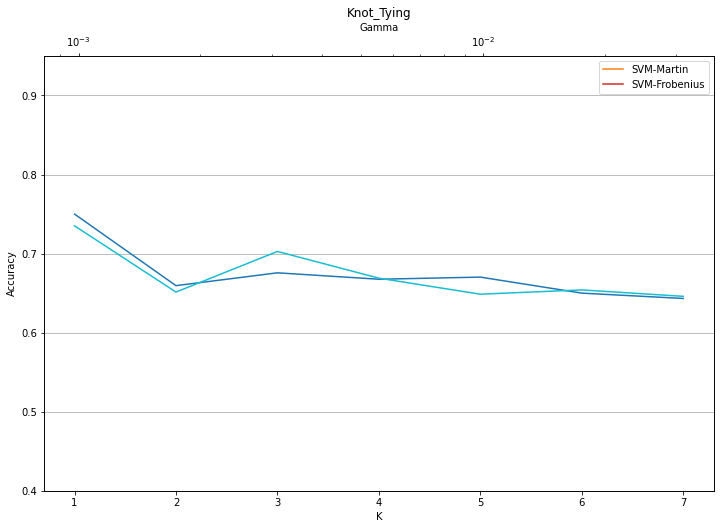

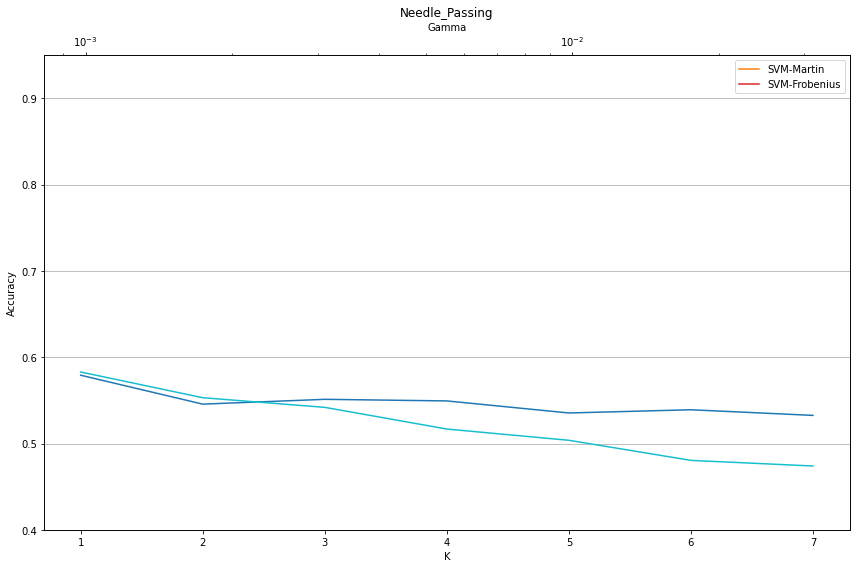

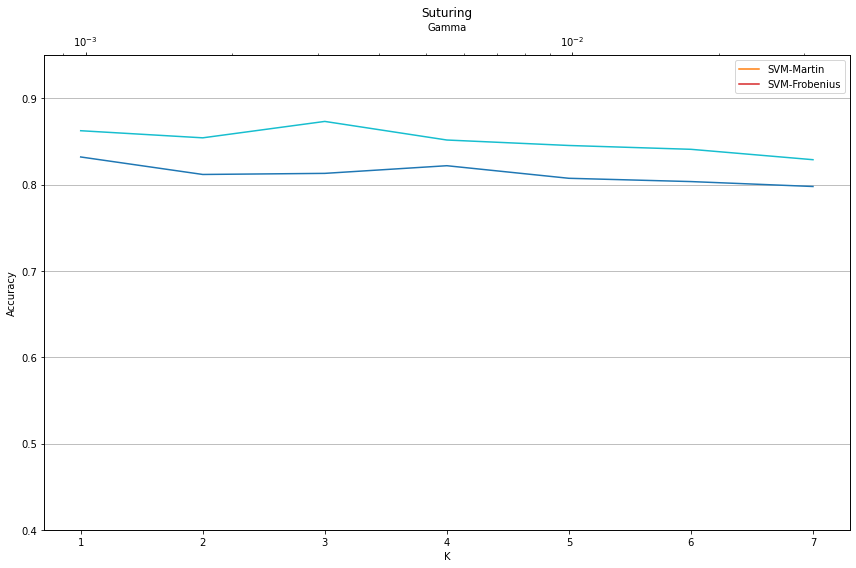

AttributeError: 'AxesSubplot' object has no attribute 'show'

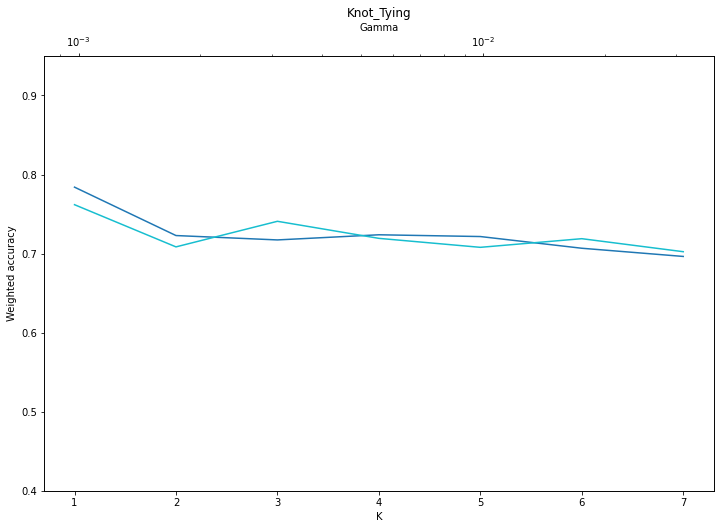

In [10]:
task_algo_accuracies = pickle.load(open('data_generated/jigsaws_eval_accuracies_baseline.pkl', 'rb'))
task_algo_weighted_accuracies = pickle.load(open('data_generated/jigsaws_eval_weighted_accuracies_baseline.pkl', 'rb'))
task_algo_confusions = pickle.load(open('data_generated/jigsaws_eval_confusions_baseline.pkl', 'rb'))
colors_KNN = ['tab:blue', 'tab:cyan']
colors_SVM = ['tab:orange', 'tab:red']
yrange =(0.4, 0.95)

# Accuracy
for task in range(ntask):
    plt.figure(figsize=(12,8))
    plt.xlabel('K')
    plt.ylabel('Accuracy')
    plt.grid(axis='y')
    plt.ylim(yrange)
    algo = 'KNN'
    for j, dist_name in enumerate(['Martin', 'Frobenius']):
        plt.plot(ks, task_algo_accuracies[f'{task}-{algo}-{dist_name}'], label=f'{algo}-{dist_name}',
                color=colors_KNN[j])

    ax1 = plt.gca()
    ax2 = ax1.twiny()
    ax2.set_xlabel('Gamma')
    ax2.tick_params(axis='x')
    ax2.set_xscale('log')

    algo = 'SVM'
    for j, dist_name in enumerate(['Martin', 'Frobenius']):
        ax2.plot(gammas, task_algo_accuracies[f'{task}-{algo}-{dist_name}'], label=f'{algo}-{dist_name}',
                color=colors_SVM[j])
    plt.savefig('data_generated/report_figures/evaluation_jigsaws_weighted_accuracy_baseline_%s.png' % i2task[task])
    plt.title(i2task[task])
    if task > 0:
        plt.tight_layout()
    plt.legend()
    plt.show()

# Weighted accuracy
for task in range(ntask):
    plt.figure(figsize=(12,8))
    plt.xlabel('K')
    plt.ylabel('Weighted accuracy')
    algo = 'KNN'
    for j, dist_name in enumerate(['Martin', 'Frobenius']):
        plt.plot(ks, task_algo_weighted_accuracies[f'{task}-{algo}-{dist_name}'], label=f'{algo}-{dist_name}',
                color=colors_KNN[j])

    ax1 = plt.gca()
    ax2 = ax1.twiny()
    ax2.set_xlabel('Gamma')
    ax2.tick_params(axis='x')
    ax2.set_xscale('log')

    algo = 'SVM'
    for j, dist_name in enumerate(['Martin', 'Frobenius']):
        ax2.plot(gammas, task_algo_weighted_accuracies[f'{task}-{algo}-{dist_name}'], label=f'{algo}-{dist_name}',
                color=colors_SVM[j])
    plt.grid(axis='y')
    plt.ylim(yrange)
    plt.savefig('data_generated/report_figures/evaluation_jigsaws_weighted_accuracy_baseline_%s.png' % i2task[task])
    plt.title(i2task[task])
    plt.show()

#for task in range(ntask):
#    for dist_name in ['Martin', 'Frobenius']:
#        best_ki = np.argmin(task_algo_accuracies[f'{task}-KNN-{dist_name}'])
#        matfig = plt.figure(figsize=(6,6))
#        plt.matshow(task_algo_confusions[f'{task}-SVM-{dist_name}'][best_ki], fignum=matfig.number)
#        plt.colorbar()
#        plt.title(f'Confusion matrix for k={ks[best_ki]}, {dist_name} distance')
#        plt.xlabel('Predicted')
#        plt.ylabel('True label')
#        plt.show()
#
#for task in range(ntask):
#    for dist_name in ['Martin', 'Frobenius']:
#        best_gammaz = np.argmin(task_algo_accuracies[f'{task}-KNN-{dist_name}'])
#        matfig = plt.figure(figsize=(6,6))
#        plt.matshow(task_algo_confusions[f'{task}-SVM-{dist_name}'][best_gammai], fignum=matfig.number)
#        plt.colorbar()
#        plt.title(f'Confusion matrix for gamma={gammas[best_gammai]}, {dist_name} distance')
#        plt.xlabel('Predicted')
#        plt.ylabel('True label')
#        plt.show()

## Evaluation for all tasks and subjects using joint fine tuning

In [ ]:
ks = np.arange(1, 8)
gammas = np.logspace(-10, -5, base=2, num=10)
ncomp = 10

num_epoch_tune = 15
lrs = np.logspace(-6, -3, num=8)
verbose = True

task_algo_accuracies = {}
task_algo_weighted_accuracies = {}
task_algo_confusions = {}
subject_gestures = [[] for _ in range(ntask)]
start = time()
for task in range(ntask):
    print(i2task[task]+':')
    task_dir = 'data/JIGSAWS_converted/'+i2task[task]
    stream = os.popen("find %s -name '*.avi' | sed 's:^.*_\([A-Z][0-9]\{3\}\)_[^_]\+$:\\1:'" % task_dir)
    video_meta = list(filter(lambda x: x != '', stream.read().split('\n')))
    task_subjects = np.unique([x[0] for x in video_meta])

    # Extract all gestures present in current task for confusions matrices
    stream = os.popen("find %s -wholename '*/transcriptions/*.txt' | xargs cat | cut -d' ' -f3 | sed -e 's/G//' -re 's/\s+$//' | sort -u" % task_dir)
    task_gestures = np.array([int(g) for g in np.array(stream.read().split('\n')) if g != ''])
    task_gestures.sort()

    for dist, dist_name in [(martin_dist, 'Martin'), (frob_dist, 'Frobenius')]:
        for algo, nhyper in [('KNN', len(ks)), ('SVM', len(gammas))]:
            task_algo_weighted_accuracies[f'{task}-{algo}-{dist_name}'] = np.zeros(nhyper)
            task_algo_accuracies[f'{task}-{algo}-{dist_name}'] = np.zeros(nhyper)
            task_algo_confusions[f'{task}-{algo}-{dist_name}'] = np.zeros((nhyper, len(task_gestures), len(task_gestures)))
        count_gesture_presence_knn = np.zeros((len(ks), len(task_gestures), len(task_gestures)))
        count_gesture_presence_svm = np.zeros((len(gammas), len(task_gestures), len(task_gestures)))
        for subject in task_subjects:
            # Load data and fit the systems separately (baseline)
            video_data, y = load_video_data(tasks=task, subjects=subject, gestures=gestures_for_tasks[task])
            nsample = len(y)
            gestures = np.unique(y)
            gestures.sort()
            subject_gestures[task].append(gestures)
            missing_gestures_indices = np.where(~np.in1d(task_gestures, gestures))[0]
            ngestures = len(gestures)
            g2i = {g: i for i, g in enumerate(gestures)}
            X = []
            mask_videos = np.full(y.shape, True)
            for vi, video in enumerate(video_data):
                if video.duration_frames < ncomp:
                    # Filter too short fragments, frames in annotations do not correspond to videos
                    mask_videos[vi] = False
                    continue
                video.torch = False
                all_frames = video.get_all_frames()

                compression_model = custom_pca(ncomp)
                compression_model.fit(all_frames)
                frames_enc, shape = compression_model.encode(all_frames)
                A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

                ############### Fine tuning ###############
                video.torch = True

                # Initialize PCA autoencoder and frame predictor
                np.random.seed(seed)
                torch.manual_seed(seed)
                compression_model = PCAAutoEncoder((1, video.height, video.width), ncomp, pca_model.mean, pca_model.std)
                state_dict = compression_model.state_dict()
                state_dict['to_lower_rep.weight'] = torch.from_numpy(pca_model.C.T)
                state_dict['to_lower_rep.bias'] = torch.zeros_like(state_dict['to_lower_rep.bias'])
                state_dict['from_lower_rep.weight'] = torch.from_numpy(pca_model.C)
                state_dict['from_lower_rep.bias'] = torch.zeros_like(state_dict['from_lower_rep.bias'])
                compression_model.load_state_dict(state_dict)
                compression_model = compression_model.to(device)

                model_ds = FramePredictor(compression_model)
                state_dict = model_ds.state_dict()
                state_dict['predictor.weight'] = torch.from_numpy(A.T)
                state_dict['predictor.bias'] = torch.zeros_like(state_dict['predictor.bias'])
                model_ds.load_state_dict(state_dict)
                model_ds = model_ds.to(device)

                # Compute original loss
                all_frames_pred = []
                for frames in video:
                    frames = frames.to(device)
                    enc = compression_model.encode(frames)
                    all_frames_pred.append(compression_model.decode(model_ds(enc)))
                all_frames_pred = torch.cat(all_frames_pred, 0)
                all_frames_pred = all_frames_pred[:-1]
                original_loss = reconstruction_error(all_frames_pred, video.get_all_frames()[1:])
                if verbose:
                    print('Original loss:', original_loss)

                # Fine tune
                np.random.seed(seed)
                torch.manual_seed(seed)
                iteration_per_epoch = np.ceil(video.duration_frames/video.batch_size)
                optimizer = Adam(list(compression_model.parameters())+list(model_ds.parameters()), lr=)
                losses = []
                losses.append(original_loss)
                for epoch in range(num_epoch_tune):
                    epoch_loss = 0
                    for frames in video:
                        frames = frames.to(device)
                        frames_next_gt = frames[1:]
                        frames_enc = compression_model.encode(frames[:-1])
                        frames_next = compression_model.decode(model_ds(frames_enc))
                        frames_next = frames_next

                        loss = crit(frames_next, frames_next_gt)
                        epoch_loss += loss.item()

                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                    losses.append(epoch_loss/iteration_per_epoch)

                # Compute resulting loss
                all_frames_pred = []
                for frames in video:
                    frames = frames.to(device)
                    enc = compression_model.encode(frames)
                    all_frames_pred.append(compression_model.decode(model_ds(enc)))
                all_frames_pred = torch.cat(all_frames_pred, 0)
                all_frames_pred = all_frames_pred[:-1]
                resulting_loss = reconstruction_error(all_frames_pred, video.get_all_frames()[1:])

                ############ End of fine tuning ############

                X.append((compression_model, A))
            y = y[mask_videos]

            # Compute all distances
            full_gram_matrix = np.zeros((len(X), len(X)))
            for i, mi in enumerate(X):
                for j, mj in enumerate(X):
                    if i > j:
                        full_gram_matrix[i,j] = full_gram_matrix[j,i]
                    else:
                        # Check: negative values appear when computing distance. For the moment round them to zero
                        # while verifying they are all small enough
                        dist_curr = dist(mi, mj)
                        if dist_curr < -1e-13:
                            raise ValueError('Negative values should not appear.')

                        full_gram_matrix[i,j] = dist_curr
            full_gram_matrix[full_gram_matrix < 0] = 0

            # Evaluation using KNN
            confusions_matrices = np.zeros((len(ks), len(task_gestures), len(task_gestures)))
            for ki, k in enumerate(ks):
                knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed', n_jobs=-1)
                accuracy, weighted_accuracy, conf_matrix = evaluate_model(knn, full_gram_matrix, y, gestures)
                task_algo_accuracies[f'{task}-KNN-{dist_name}'][ki] += accuracy/len(task_subjects)
                task_algo_weighted_accuracies[f'{task}-KNN-{dist_name}'][ki] += weighted_accuracy/len(task_subjects)
                current_gesture_presence = np.ones(conf_matrix.shape)
                for ax in [0,1]:
                    for gi in missing_gestures_indices:
                        conf_matrix = np.insert(conf_matrix, gi, 0, axis=ax)
                        current_gesture_presence = np.insert(current_gesture_presence, gi, 0, axis=ax)
                confusions_matrices[ki] = conf_matrix
                count_gesture_presence_knn += current_gesture_presence

            task_algo_confusions[f'{task}-KNN-{dist_name}'] += confusions_matrices

            # Evaluation using SVM
            svm_model = SVC()
            confusions_matrices = np.zeros((len(gammas), len(task_gestures), len(task_gestures)))
            for gammai, gamma in enumerate(gammas):
                accuracy, weighted_accuracy, conf_matrix = evaluate_model(svm_model, full_gram_matrix, y, gestures, d_transform=lambda x: np.exp(-gamma*x))
                task_algo_accuracies[f'{task}-SVM-{dist_name}'][gammai] += accuracy/len(task_subjects)
                task_algo_weighted_accuracies[f'{task}-SVM-{dist_name}'][gammai] += weighted_accuracy/len(task_subjects)
                current_gesture_presence = np.ones(conf_matrix.shape)
                for ax in [0,1]:
                    for gi in missing_gestures_indices:
                        conf_matrix = np.insert(conf_matrix, gi, 0, axis=ax)
                        current_gesture_presence = np.insert(current_gesture_presence, gi, 0, axis=ax)
                confusions_matrices[gammai] = conf_matrix
                count_gesture_presence_svm += current_gesture_presence

            task_algo_confusions[f'{task}-SVM-{dist_name}'] += confusions_matrices

            print('\tSubject '+subject+': '+sec2string(time()-start))
        task_algo_confusions[f'{task}-KNN-{dist_name}'] /= count_gesture_presence_knn
        task_algo_confusions[f'{task}-SVM-{dist_name}'] /= count_gesture_presence_svm
    print('End of task', i2task[task], ':', sec2string(time()-start))